#### The below code is only useful if running in a linux instance and you want to download the datasets directly

In [ ]:
# coding: utf-8

# In this notebook I benchmark a few text categorization models to test whehter word embeddings like word2vec can improve text classification accuracy. The the notebook proceeds as follows:
# 1. downloading the datasets
# 2. construction of the training set
# 3. definitions of models
# 4. benchmarking models
# 5. plotting results

# Downloading datasets and pretrained wector embeddings. Especially the embeddings can take a while to download. You might want run these in the terminal instead to see wget's progress bar. If you're on Windows (and not in cygwin) %%bash cell magic won't work and you'll have to do all this manually (or with %%cmd magic I guess). 

# In[ ]:

get_ipython().run_cell_magic('bash', '', "# download Reuters' text categorization benchmarks\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-no-stop.txt\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-test-no-stop.txt\n# concatenate train and test files, we'll make our own train-test splits\ncat r8-*-no-stop.txt > r8-no-stop.txt\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-train-no-stop.txt\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-test-no-stop.txt\ncat r52-*-no-stop.txt > r52-no-stop.txt\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt\nwget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-train-no-stop.txt\ncat 20ng-*-no-stop.txt > 20ng-no-stop.txt")


# In[ ]:

get_ipython().run_cell_magic('bash', '', '# download GloVe word vector representations\n# bunch of small embeddings - trained on 6B tokens - 822 MB download, 2GB unzipped\nwget http://nlp.stanford.edu/data/glove.6B.zip\nunzip glove.6B.zip\n\n# and a single behemoth - trained on 840B tokens - 2GB compressed, 5GB unzipped\nwget http://nlp.stanford.edu/data/glove.840B.300d.zip\nunzip glove.840B.300d.zip')

#### Download the train-test data
Follow these links to download all the data.
http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-no-stop.txt
http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-test-no-stop.txt 
concatenate train and test files by running the following from the terminal, must be in the correct directory
cat r8-*-no-stop.txt > r8-no-stop.txt

http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-train-no-stop.txtt http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-test-no-stop.txt
cat r52-*-no-stop.txt > r52-no-stop.txt

http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-train-no-stop.txt
cat 20ng-*-no-stop.txt > 20ng-no-stop.txt"

#### Download glove word embeddings
bunch of small embeddings - trained on 6B tokens - 822 MB download, 2GB unzipped
http://nlp.stanford.edu/data/glove.6B.zip
and a single behemoth - trained on 840B tokens - 2GB compressed, 5GB unzipped http://nlp.stanford.edu/data/glove.840B.300d.zip


In [1]:
# In[4]:

from tabulate import tabulate
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

C:\Users\arlangsner\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\arlangsner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### set data paths

In [2]:
# TRAIN_SET_PATH = "20ng-no-stop.txt"
# TRAIN_SET_PATH = "r52-all-terms.txt"
TRAIN_SET_PATH = "data/r8-no-stop.txt"

GLOVE_6B_50D_PATH = "data/glove.6B/glove.6B.50d.txt"
GLOVE_840B_300D_PATH = "data/glove.6b/glove.6B.300d.txt"

#### Load the R8 training data
The first word is the category label separated from the tokenized text of the document by a tab ('\t'). This creates two arrays. One with the list of categories, and the other with the tokenized text which can be used to create a document-term matrix (DTM) for training.

In [3]:
X, y = [], []
with open(TRAIN_SET_PATH, "r") as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print("total examples %s" % len(y))

total examples 7674


#### Prepare word embeddings - both the downloaded pretrained ones and train a new one from scratch
Each word is matched with a vector of 50 dimensions from the 50D glove file.
This is important later on.

Could trying loading the 300D word vectors instead to compare results.

In [4]:
with open(GLOVE_6B_50D_PATH, "r", encoding='utf8') as lines:
    word2vec = {line.split()[0]: np.array(list(map(float, line.split()[1:])))
               for line in lines}

#### Read in the glove files
Only include words that are in the R8 training data

In [5]:
# In[32]:

# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words) # creates a list of all the unique words
# below: checks that a pre-trained word is in the training set, then adds word and vector to the glove small dictionary
with open(GLOVE_6B_50D_PATH, "rt", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_small[word] = np.array(nums)

# same as above for the big word set
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rt", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_big[word] = np.array(nums)

#### Train word2vec on all the texts - both training and test set
This uses the Word2Vec library to train new 100D word vectors on the training set as the corpus.

In [6]:
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=4)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

#### Model definitions
These are the models we train on the DTM without using any pretrained word embeddings.

CountVectorizer - creates a document term matrix where values represent the of times ea. term is in ea. documents

TfidfVectorizer - creates a DTM where each value is the tf-idf weight of the term in ea. documents

Multinomial Naive Bayes - evaluates the dtm count matrix

Bernoulli Naive Bayes - converts the dtm to a binary matrix before processing, this can be better for short documents

SVM - which is supposed to be more or less state of the art 
http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf

In [7]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

#### Classifiers using word-vector embeddings. 
We implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [8]:
# Even after reading the python documentation on classes, I'm not 100% how this works despite knowing what it does.
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

#### Set up models using the document vectors
The document vectors are created by averaging (directly or through tfidf weighting) the word vectors in each document (see classes above).

There are better ways to do this including using doc2vec.

In [ ]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

#### Benchmark everything together
In other words, we test each model on the training and test data.

In [10]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models],
                key=lambda x: x[1])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model                score
-----------------  -------
bern_nb             0.7954
bern_nb_tfidf       0.7954
mult_nb_tfidf       0.8615
glove_small_tfidf   0.9082
glove_small         0.9245
glove_big_tfidf     0.9252
glove_big           0.9385
mult_nb             0.9467
w2v                 0.9539
svc                 0.9562
w2v_tfidf           0.9565
svc_tfidf           0.9656


#### Plot the results

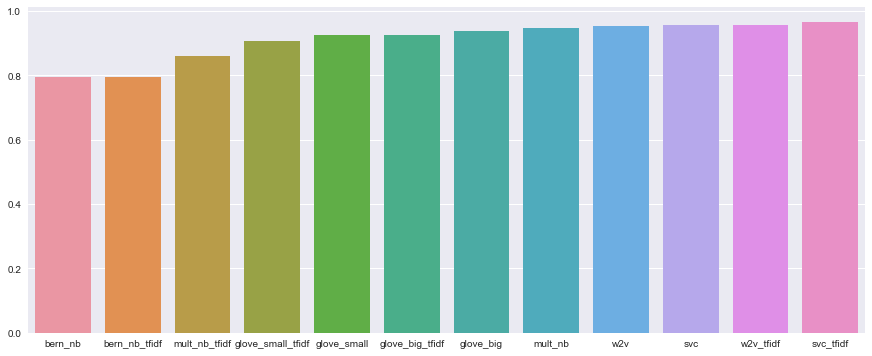

In [11]:
# In[38]:

plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])


#### Ranking based on amount of training data.
Word embedding models which are semi-supervised should shine when there is very little labeled training data. This is because the word embeddings are pretrained on a large corpus of data (e.g. wikipedia) and are already meaningful on their own.

In [12]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [13]:
train_sizes = [10, 40, 160, 640, 3200, 6400]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

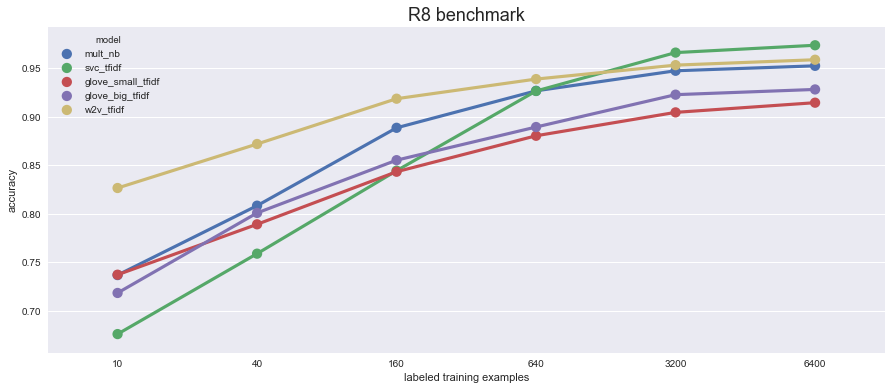

In [14]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")


# Let's be lazy and instead of refactoring, just copy the above code changing the input path to reuters 52

### Start over with 52 categories of data.

In [19]:
# In[46]:

TRAIN_SET_PATH = "data/r52-no-stop.txt"

X, y = [], []
with open(TRAIN_SET_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print("total examples %s" % len(y))

total examples 9100


In [23]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_small[word] = np.array(nums)
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_big[word] = np.array(nums)
            
            

In [24]:
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=4)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [25]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [27]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models], 
                key=lambda x: x[1])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

C:\Users\arlangsner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\arlangsner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\arlangsner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\Users\arlangsner\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum numb

model                score
-----------------  -------
bern_nb             0.6668
bern_nb_tfidf       0.6668
mult_nb_tfidf       0.7257
glove_small_tfidf   0.8437
glove_small         0.8551
glove_big_tfidf     0.8606
mult_nb             0.8740
glove_big           0.8795
w2v                 0.8841
w2v_tfidf           0.8946
svc                 0.9204
svc_tfidf           0.9384


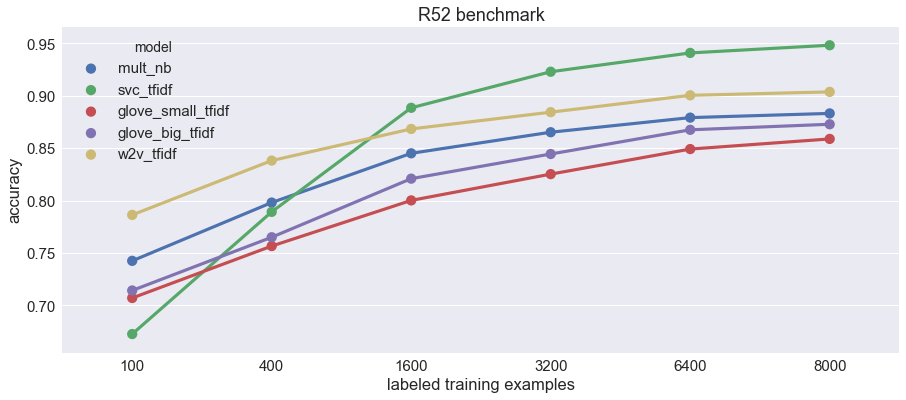

In [28]:
train_sizes = [100, 400, 1600, 3200, 6400, 8000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R52 benchmark")
fig.set(ylabel="accuracy")

total examples 18821
model                score
-----------------  -------
w2v                 0.5794
w2v_tfidf           0.6246
glove_small_tfidf   0.6534
glove_small         0.6535
bern_nb             0.7163
bern_nb_tfidf       0.7163
glove_big_tfidf     0.7191
glove_big           0.7227
svc                 0.7973
mult_nb_tfidf       0.8470
mult_nb             0.8593
svc_tfidf           0.8834


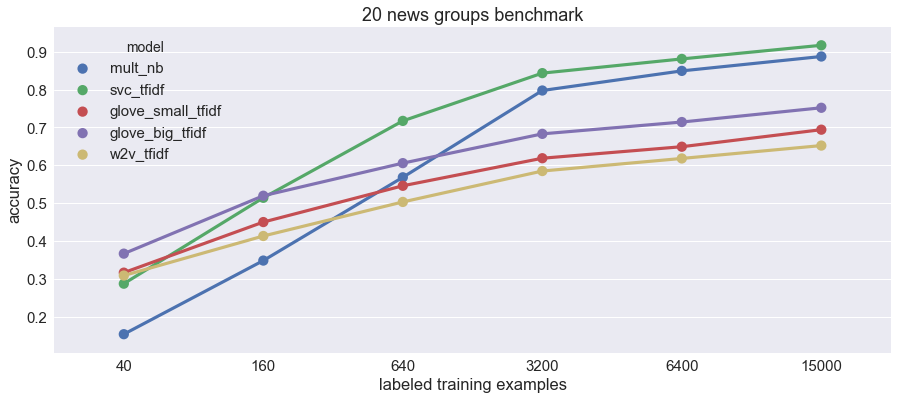

In [32]:
# And now the 20 news group dataset 

# In[49]:

TRAIN_SET_PATH = "data/20ng-no-stop.txt"

X, y = [], []
with open(TRAIN_SET_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print("total examples %s" % len(y))


# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_small[word] = np.array(nums)
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "r", encoding='utf8') as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = list(map(float, parts[1:]))
        if word in all_words:
            glove_big[word] = np.array(nums)
            
            
            
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}



# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])




all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models], 
                key=lambda x: x[1])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))



train_sizes = [40, 160, 640, 3200, 6400, 15000]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="20 news groups benchmark")
fig.set(ylabel="accuracy")


# In[ ]: